In [2]:
# Clearing the environment

try:
    del full_dataset, train_indices, val_indices, train_subset, val_subset, train_loader, val_loader, labels, class_names, model, criterion, optimizer
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Some are non-existent!
Memory has been reset


In [6]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

torch.cuda.empty_cache()

# Map emotion codes to readable labels
emotion_map = {
    "AN": "Anger",
    "DI": "Disgust",
    "AF": "Fear",
    "HA": "Happy",
    "NE": "Neutral",
    "SA": "Sad",
    "SU": "Surprise"
}
# For classification we need integer targets, so map them
class_names = list(emotion_map.values())
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

# Custom dataset
class KDEFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Get all jpg files
        all_images = glob.glob(os.path.join(root_dir, "**", "*.JPG"), recursive=True)

        for img_path in all_images:
            filename = os.path.basename(img_path)
            emotion_code = filename[4:6]  # letters 5 & 6
            if emotion_code in emotion_map:
                label_name = emotion_map[emotion_code]
                label_idx = class_to_idx[label_name]
                self.samples.append((img_path, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
dataset = KDEFDataset(root_dir="/kaggle/input/kdef-dataset/KDEF/", transform=transform)

labels = [lbl for _, lbl in dataset.samples]
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4)

print("Classes:", class_names, ", Total Samples:", len(dataset))
print("Train size:", len(train_subset), ", Val size:", len(val_subset))

Classes: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] , Total Samples: 4898
Train size: 3918 , Val size: 980


In [7]:
# Load pretrained Swin Transformer
import timm
model = timm.create_model('densenet121', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# mobilenetv3_small_100, resnet50/101, efficientnet_b0, inception_resnet_v2 (299), densenet121, inception_v3, regnety_032, darknet53, cspdarknet53, rexnet_200, edgenext_small, convnextv2_nano
# tiny_vit_5m_224, swin_tiny_patch4_window7_224, maxvit_nano_rw_256, davit_tiny, resnetv2_50/101x1_bit, pvt_v2_b0/b1, mobilevitv2_200, convformer/caformer_s18, twins_svt/pcpvt_small, mvitv2_tiny, visformer_tiny/small, 

print(f"Total Parameters = {sum(p.numel() for p in model.parameters())/1e6} M")
print(f"Trainable Parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6} M")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 0.001)

model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Total Parameters = 6.961031 M
Trainable Parameters = 6.961031 M


In [8]:
# For tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_path = 'best_model.pth'

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]"
          f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%"
          f"  || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with val_acc: {val_acc:.2f}%")

Epoch [1/50]  Train Loss: 1.1639 | Train Acc: 57.76%  || Val Loss: 0.5370 | Val Acc: 82.76%
Saved new best model with val_acc: 82.76%
Epoch [2/50]  Train Loss: 0.4200 | Train Acc: 85.83%  || Val Loss: 0.3926 | Val Acc: 86.73%
Saved new best model with val_acc: 86.73%
Epoch [3/50]  Train Loss: 0.2386 | Train Acc: 92.34%  || Val Loss: 0.3453 | Val Acc: 89.59%
Saved new best model with val_acc: 89.59%
Epoch [4/50]  Train Loss: 0.1351 | Train Acc: 95.89%  || Val Loss: 0.3586 | Val Acc: 89.90%
Saved new best model with val_acc: 89.90%
Epoch [5/50]  Train Loss: 0.1163 | Train Acc: 96.38%  || Val Loss: 0.2585 | Val Acc: 91.73%
Saved new best model with val_acc: 91.73%
Epoch [6/50]  Train Loss: 0.0898 | Train Acc: 97.14%  || Val Loss: 0.4773 | Val Acc: 92.55%
Saved new best model with val_acc: 92.55%
Epoch [7/50]  Train Loss: 0.0843 | Train Acc: 97.14%  || Val Loss: 0.2090 | Val Acc: 93.67%
Saved new best model with val_acc: 93.67%
Epoch [8/50]  Train Loss: 0.0682 | Train Acc: 97.88%  || Val L

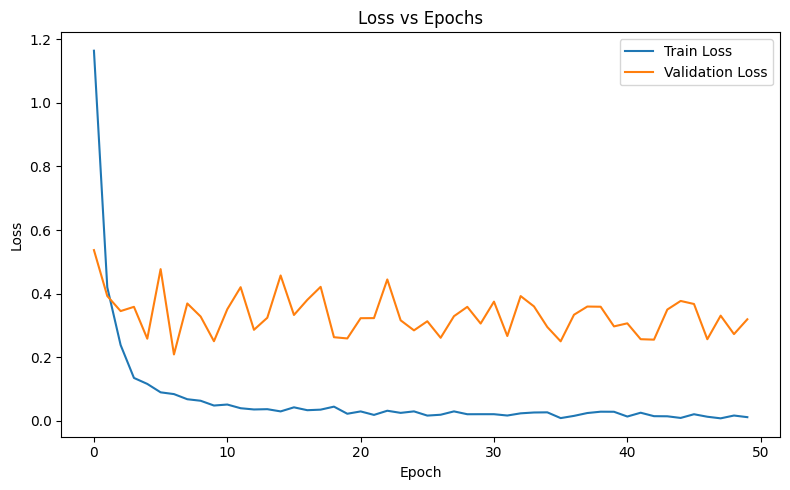

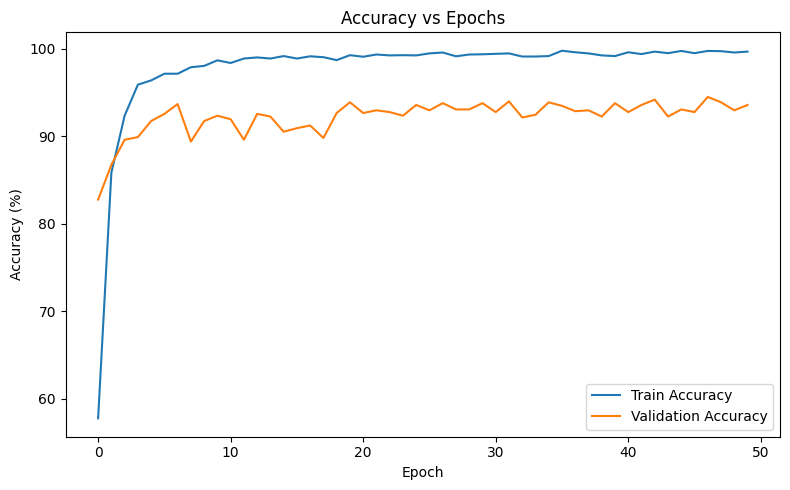

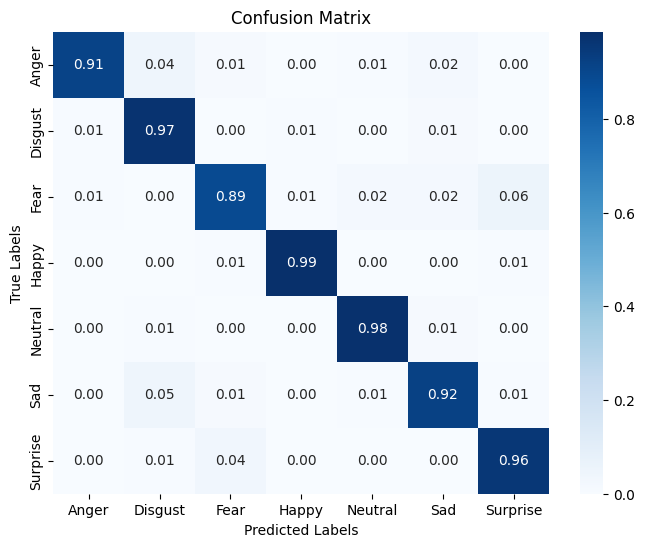

Classification Report:
              precision    recall  f1-score   support

       Anger       0.98      0.91      0.95       140
     Disgust       0.90      0.97      0.93       140
        Fear       0.93      0.89      0.91       140
       Happy       0.99      0.99      0.99       140
     Neutral       0.96      0.98      0.97       140
         Sad       0.93      0.92      0.92       140
    Surprise       0.93      0.96      0.94       140

    accuracy                           0.94       980
   macro avg       0.95      0.94      0.94       980
weighted avg       0.95      0.94      0.94       980

Confusion Matrix:
[[128   6   2   0   1   3   0]
 [  1 136   0   1   0   2   0]
 [  1   0 124   1   3   3   8]
 [  0   0   1 138   0   0   1]
 [  0   1   0   0 137   2   0]
 [  0   7   2   0   1 129   1]
 [  0   1   5   0   0   0 134]]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Loss and Accuracy
plt.figure(figsize=(8, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.savefig('Loss.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.savefig('Acc.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))